In [105]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.optimize import curve_fit
import pandas as pd
import os
import gc
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


In [37]:
# 打开 ROOT 文件，载入 events tree
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
#Energy_Train=(0.5,)
Energy_Val=(0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    #MCP_px = tree["MCParticles.momentum.x"].array(library="np")
    #MCP_py = tree["MCParticles.momentum.y"].array(library="np")
    #MCP_pz = tree["MCParticles.momentum.z"].array(library="np")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    #print to check
    # sorted_indices = np.argsort(calo_layer[0])
    # energy_sorted = energy[0][sorted_indices].to_numpy()
    # layer_sorted = calo_layer[0][sorted_indices].to_numpy()
    # posz_sorted = pos_z[0][sorted_indices].to_numpy()
    # print("Event 0 (sorted by layer):")
    # for l, e, z in zip(layer_sorted, energy_sorted, posz_sorted):
    #     print(f"  Layer {l:2d} | Energy = {e:.5f} | PosZ = {z:.5f }")

    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)

    #print("Event 0:")
    #for layer_idx, (E_val, N_val) in enumerate(zip(E_layers_all[0], N_layers_all[0])):
    #    print(f"  Layer {layer_idx:2d} | E_layer = {E_val:.5f} | N_layer = {N_val}")
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_validate, N_layers_validate, E_truth_validate = ReadData_Energy(DataPath_Validate,Energy_Val)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/3.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/4.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/6.5GeV.root

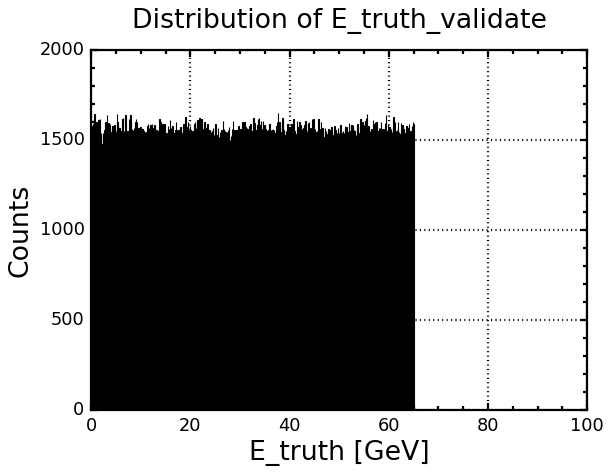

In [38]:
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.xlim(0, 100)
plt.ylabel("Counts")
plt.title("Distribution of E_truth_validate")
plt.grid(True)
plt.show()

In [63]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    print(len(E_layers),len(N_layers),len(E_truth))
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_validate, N_layers_validate, E_sum_val, N_sum_val, E_truth_validate = Event_Selection(E_layers_validate, N_layers_validate, E_truth_validate)

849995 849995 849995
1000098 1000098 1000098
50000 50000 50000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24877
[LightGBM] [Info] Number of data points in the train set: 1000098, number of used features: 122
[LightGBM] [Info] Start training from score 32.604428
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1.07523	training's l2: 1.15611	valid_1's rmse: 0.87394	valid_1's l2: 0.763771


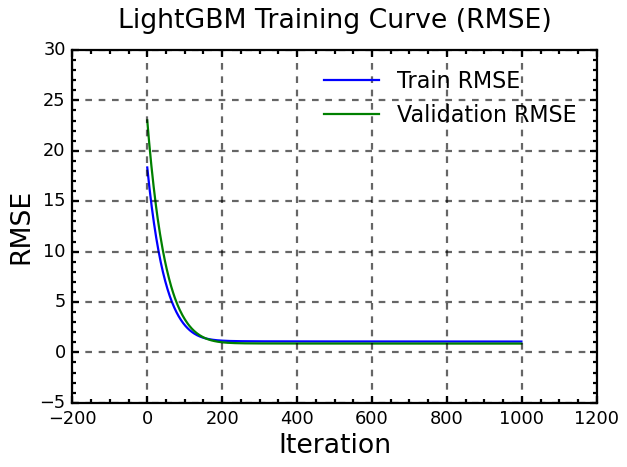

/data_ilc/flc/shi/miniconda3/envs/my_notebook_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


===== LightGBM Model Summary =====
Initial Model Parameters:
  boosting_type: gbdt
  class_weight: None
  colsample_bytree: 1.0
  importance_type: split
  learning_rate: 0.02
  max_depth: 7
  min_child_samples: 100
  min_child_weight: 0.001
  min_split_gain: 0.0
  n_estimators: 1000
  n_jobs: None
  num_leaves: 16
  objective: regression_l2
  random_state: 42
  reg_alpha: 0.0
  reg_lambda: 0.0
  subsample: 1.0
  subsample_for_bin: 200000
  subsample_freq: 0
Final Model Parameters:

Trained model statistics:
  Number of trees   : 1000
  Max tree depth    : 1
  Max number of leaves per tree : 16


In [ ]:
#light gradient boost
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
def get_max_depth(tree):
    if "left_child" not in tree and "right_child" not in tree:
        return 1
    left_depth = get_max_depth(tree["left_child"]) if "left_child" in tree else 0
    right_depth = get_max_depth(tree["right_child"]) if "right_child" in tree else 0
    return 1 + max(left_depth, right_depth)


def summarize_lgbm_model(lgb_reg):
    booster = lgb_reg.booster_
    model_info = booster.dump_model()
    print("===== LightGBM Model Summary =====")
    print("Initial Model Parameters:")
    for k, v in lgb_reg.get_params().items():
        print(f"  {k}: {v}")
    print("Final Model Parameters:")

    trees = model_info['tree_info']
    num_trees = len(trees)
    max_depth = get_max_depth(trees)
    num_leaves = max(tree['num_leaves'] for tree in trees)
    
    print("\nTrained model statistics:")
    print(f"  Number of trees   : {num_trees}")
    print(f"  Max tree depth    : {max_depth}")
    print(f"  Max number of leaves per tree : {num_leaves}")

def lightgbm_train(X_train, y_train, X_val, y_val):
    lgb_reg = lgb.LGBMRegressor(
        objective='regression_l2',
        n_estimators=1000,           # 设大一些，early stopping 会截断
        learning_rate=0.02,
        max_depth=7,
        num_leaves=32,
        min_child_samples=100,
        random_state=42
    )
    lgb_reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    # --- 可视化 RMSE ---
    evals_result = lgb_reg.evals_result_
    plt.figure(figsize=(8, 6))
    plt.plot(evals_result['training']['rmse'], label='Train RMSE')
    plt.plot(evals_result['valid_1']['rmse'], label='Validation RMSE')
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.title("LightGBM Training Curve (RMSE)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    return lgb_reg

E_ratio_train   = [layer / layer.sum() for layer in E_layers_train]
E_ratio_val     = [layer / layer.sum() for layer in E_layers_validate]
E_ratio_uniform = [layer / layer.sum() for layer in E_layers_uniform]
N_ratio_train   = [layer / layer.sum() for layer in N_layers_train]
N_ratio_val     = [layer / layer.sum() for layer in N_layers_validate]
N_ratio_uniform = [layer / layer.sum() for layer in N_layers_uniform]

X_train = np.hstack([E_layers_uniform, E_ratio_uniform, E_sum_uniform[:, np.newaxis], N_layers_uniform, N_ratio_uniform, N_sum_uniform[:, np.newaxis]])
X_val = np.hstack([E_layers_validate, E_ratio_val, E_sum_val[:, np.newaxis], N_layers_validate, N_ratio_val, N_sum_val[:, np.newaxis]])
y_train = E_truth_uniform
y_val = E_truth_validate
#mask = (E_truth_uniform > 0) & (E_truth_uniform < 1)
#X_train = X_train[mask]
#y_train = y_train[mask]

n_train = X_train.shape[0]
idx_train = np.arange(n_train)
np.random.seed(42)
np.random.shuffle(idx_train)
X_train = X_train[idx_train]
y_train = y_train[idx_train]
lgb_reg = lightgbm_train(X_train, y_train, X_val, y_val)
y_pred_val = lgb_reg.predict(X_val)
summarize_lgbm_model(lgb_reg)
del lgb_reg
gc.collect()


Reco_hist_lightgbm = []
Nbins = 50
for i_E, E_truth in enumerate(Energy_Val):
    mask = (E_truth_validate == E_truth)
    reco_energy = y_pred_val[mask]
    mean = np.mean(reco_energy)
    rms = np.std(reco_energy)
    valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)
    filtered_data = reco_energy[valid_mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    Reco_hist_lightgbm.append({
        "E_truth": E_truth,
        "counts": counts,
        "bin_edges": bin_edges
    })

In [154]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


10
{'E_truth': 0.5, 'counts': array([  3,   2,  24,  67, 125, 192, 209, 185, 203, 196, 280, 281, 271,
       340, 419, 476, 399, 245, 213, 117, 104,  84,  94,  90,  73,  46,
        31,  37,  38,  31,  24,  24,  11,  14,   8,   3,   5,   6,   1,
         6,   6,   1,   2,   0,   0,   1,   0,   0,   0,   1]), 'bin_edges': array([0.29670573, 0.31414176, 0.33157778, 0.34901381, 0.36644983,
       0.38388586, 0.40132188, 0.41875791, 0.43619394, 0.45362996,
       0.47106599, 0.48850201, 0.50593804, 0.52337406, 0.54081009,
       0.55824612, 0.57568214, 0.59311817, 0.61055419, 0.62799022,
       0.64542624, 0.66286227, 0.6802983 , 0.69773432, 0.71517035,
       0.73260637, 0.7500424 , 0.76747843, 0.78491445, 0.80235048,
       0.8197865 , 0.83722253, 0.85465855, 0.87209458, 0.88953061,
       0.90696663, 0.92440266, 0.94183868, 0.95927471, 0.97671073,
       0.99414676, 1.01158279, 1.02901881, 1.04645484, 1.06389086,
       1.08132689, 1.09876291, 1.11619894, 1.13363497, 1.15107099,
       

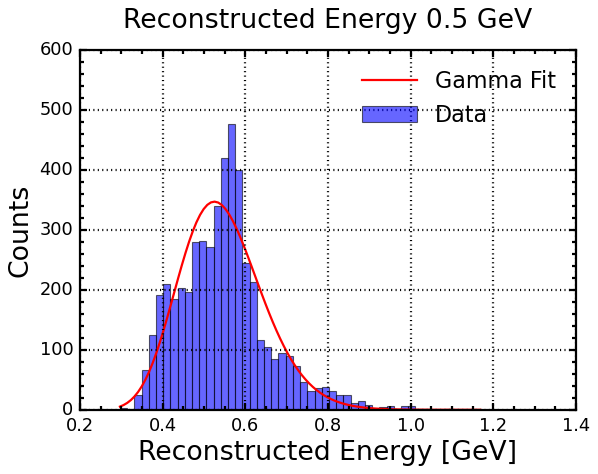

In [155]:
#This cell is left here for debug
i_E = 0  # Example index, change as needed
print(len(Reco_hist_lightgbm))
print(Reco_hist_lightgbm[i_E])
peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all("E_reco",Reco_hist_lightgbm[i_E]["E_truth"],Reco_hist_lightgbm[i_E]["counts"],Reco_hist_lightgbm[i_E]["bin_edges"])





Mean: 0.5475391096764262, Peak: 0.5669641287608514, RMS: 0.10985982648907744
Initial Gamma Fit Parameters: [86.970896531087, 2.283212966347206, 0.2967057293559103, 0.10985982648907744]
Gamma Fit Parameters: [8.56310689e+01 2.28321297e+01 6.68063411e-02 2.09955874e-02]
Gamma Fit Peak: 0.5251847280069365 ± 0.008782739559114846, Resolution: 0.19102453552616275 ± 0.013341697752575397


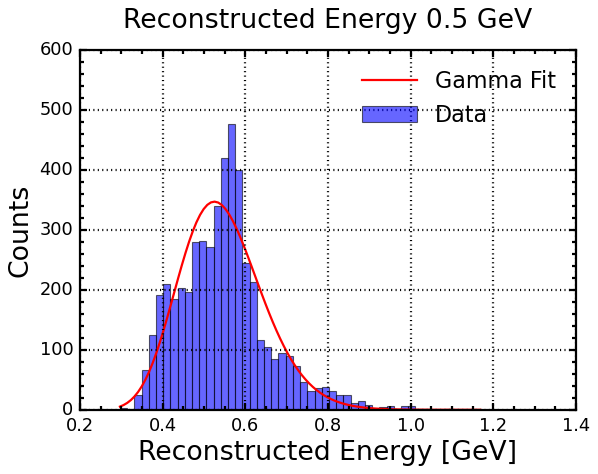

Mean: 1.0278446782443418, Peak: 1.0759739913945758, RMS: 0.1859223316684475
Initial Gamma Fit Parameters: [146.65411502928754, 3.292118176601499, 0.41576639072251337, 0.1859223316684475]
Gamma Fit Parameters: [ 1.47629225e+02  3.29211818e+01 -5.65921299e-02  3.30287657e-02]
Gamma Fit Peak: 0.9977251046358031 ± 0.010525067381888104, Resolution: 0.1899411892866694 ± 0.008096028651471871


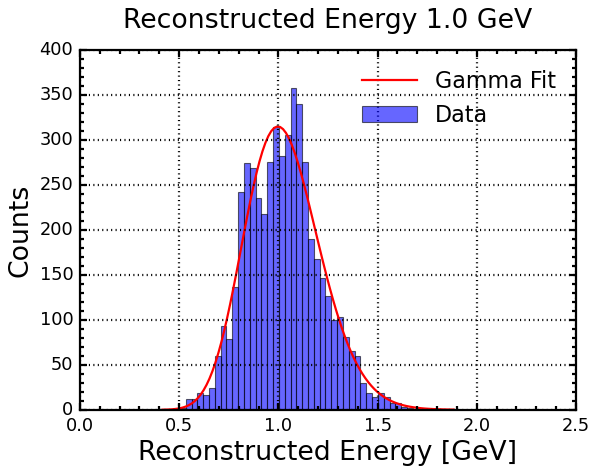

Mean: 2.024167256188785, Peak: 2.024167256188785, RMS: 0.2607893965106442
Initial Gamma Fit Parameters: [209.79756280268336, 2.9783304956793786, 1.2474502436113122, 0.2607893965106442]
Gamma Fit Parameters: [2.09492848e+02 2.97833050e+01 6.04907072e-01 4.77684239e-02]
Gamma Fit Peak: 1.979840183359257 ± 0.009911326770308367, Resolution: 0.13167314888248902 ± 0.003751144252170203


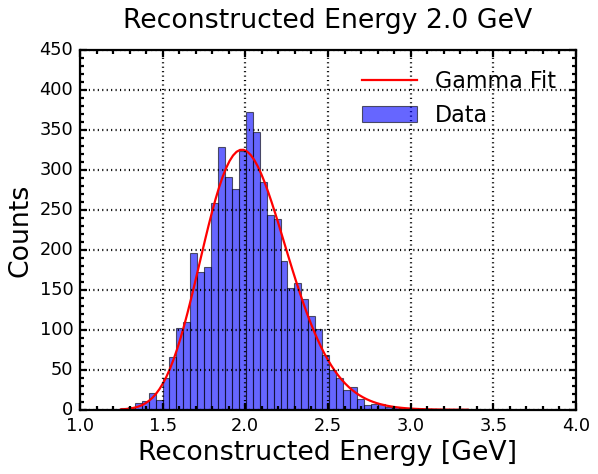

Mean: 5.034234255451512, Peak: 4.9317601944131235, RMS: 0.409414948410586
Initial Gamma Fit Parameters: [324.0256271690105, 3.3381284551394232, 3.667554566202696, 0.409414948410586]
Gamma Fit Parameters: [3.27098716e+02 3.10858775e+01 2.67640890e+00 7.61915078e-02]
Gamma Fit Peak: 4.968697269428377 ± 0.011107905981145945, Resolution: 0.08549596061727176 ± 0.0016275246988478574


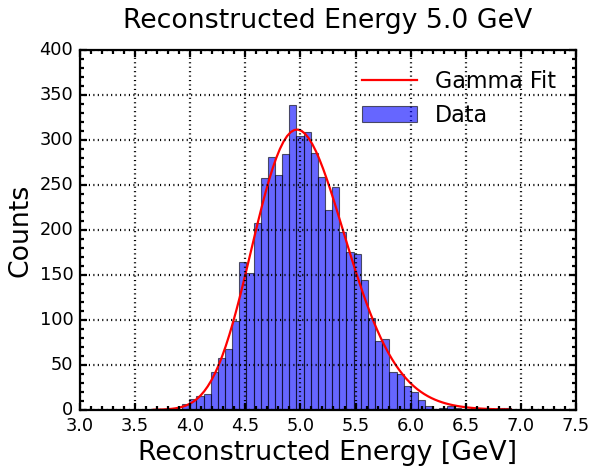

Mean: 10.03450275851283, Peak: 10.047267778321608, RMS: 0.5812592810878989
Initial Gamma Fit Parameters: [479.1204491239873, 4.515209225204044, 7.409995490309277, 0.5812592810878989]
Gamma Fit Parameters: [4.76222410e+02 4.51520923e+01 6.22822592e+00 8.52445275e-02]
Gamma Fit Peak: 9.991950161414465 ± 0.018374454705636464, Resolution: 0.05732646844596549 ± 0.001278902971391563


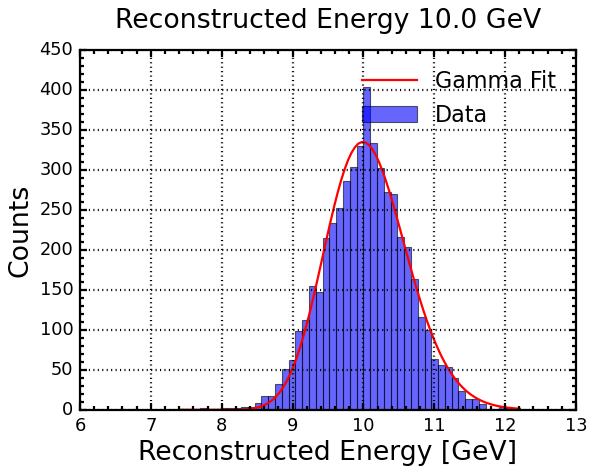

Mean: 20.028758545391614, Peak: 19.830337899188326, RMS: 0.8260612968673797
Initial Gamma Fit Parameters: [680.844579099002, 3.455890087183381, 17.17398149814179, 0.8260612968673797]
Gamma Fit Parameters: [6.76403350e+02 3.45589009e+01 1.52996163e+01 1.38181100e-01]
Gamma Fit Peak: 19.93682214531291 ± 0.01962736584083055, Resolution: 0.04074484505816433 ± 0.0006949214560320996


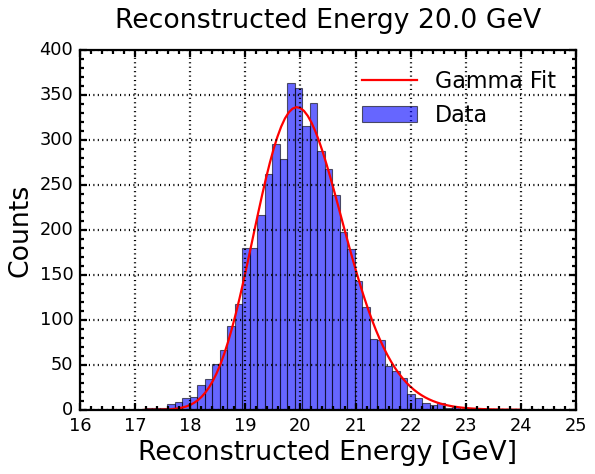

Mean: 30.01559594059975, Peak: 29.84500917656601, RMS: 1.0364170245226791
Initial Gamma Fit Parameters: [940.882766153645, 4.79634058753258, 25.044586900271874, 1.0364170245226791]
Gamma Fit Parameters: [9.41052009e+02 4.79634059e+01 2.28972887e+01 1.49600527e-01]
Gamma Fit Peak: 29.923038981124304 ± 0.020446916861130846, Resolution: 0.034624414016220934 ± 0.00046880290653523684


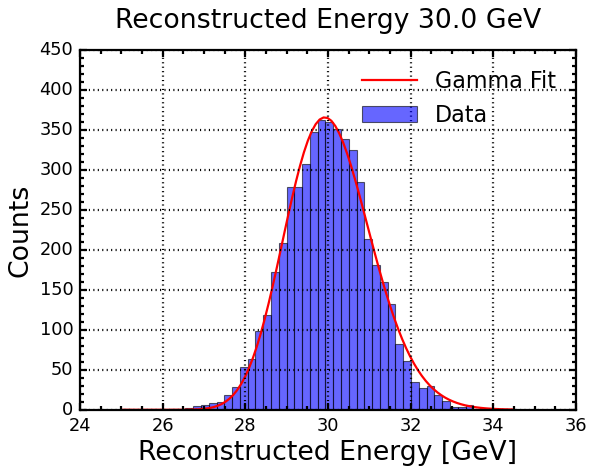

Mean: 40.02629396659183, Peak: 40.09709388755853, RMS: 1.1906497783596124
Initial Gamma Fit Parameters: [1051.68034725618, 4.271220361787545, 34.940766389504425, 1.1906497783596124]
Gamma Fit Parameters: [1.05655515e+03 4.27122036e+01 3.22004465e+01 1.85249690e-01]
Gamma Fit Peak: 39.927619332524515 ± 0.029864947085646687, Resolution: 0.03032215499242917 ± 0.0005166227368970426


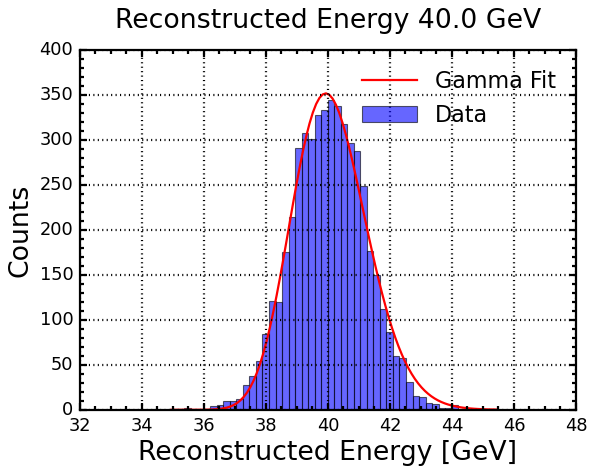

Mean: 50.06458939358243, Peak: 50.41965586832811, RMS: 1.316414665884506
Initial Gamma Fit Parameters: [912.683764550602, 3.54424673635743, 45.398891010328214, 1.316414665884506]
Gamma Fit Parameters: [9.03281377e+02 3.54424674e+01 4.24712333e+01 2.16799282e-01]
Gamma Fit Peak: 49.938335489031395 ± 0.04328468495275594, Resolution: 0.02584554831270706 ± 0.0006072442569298742


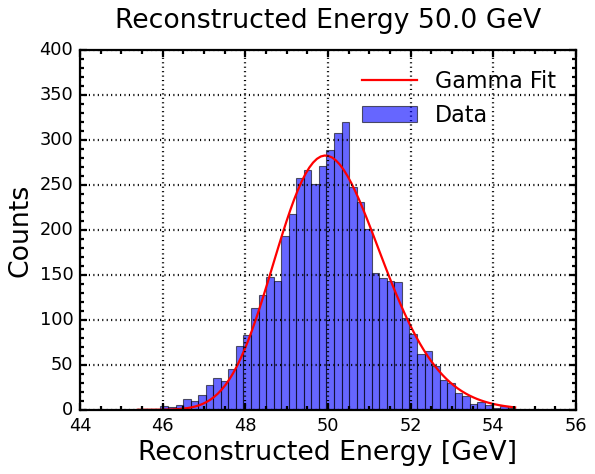

Mean: 59.999933570069366, Peak: 60.31745868542307, RMS: 1.4008451887651503
Initial Gamma Fit Parameters: [1121.8383103225804, 4.978725670529763, 53.0255096683262, 1.4008451887651503]
Gamma Fit Parameters: [1.12295131e+03 4.97872567e+01 5.00880293e+01 2.01816382e-01]
Gamma Fit Peak: 59.93409691831195 ± 0.04095312347612539, Resolution: 0.023759732572604744 ± 0.0004677420327210685


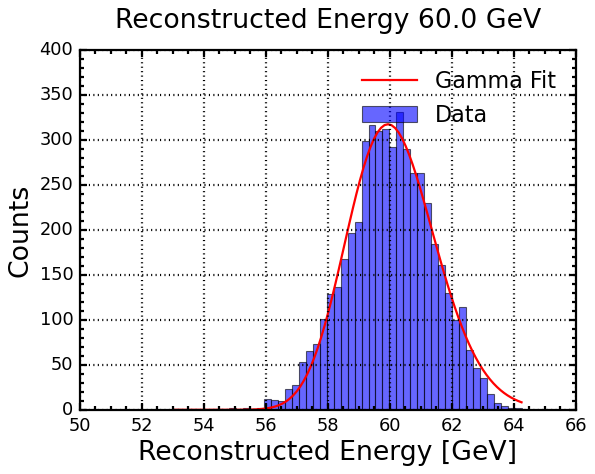

In [156]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
results = []
for i_E in range(len(Energy_Val)):
    peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0
    peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0
    peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist_lightgbm[i_E]["E_truth"],Reco_hist_lightgbm[i_E]["counts"],Reco_hist_lightgbm[i_E]["bin_edges"])
    results.append({
        "ParticleEnergy": Energy_Val[i_E],
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath_Validate, "RecoE_lightgbm_Fit.csv")
df.to_csv(outputfile_name, index=False)

